# Tutorial session: nonlinear MPC
In this tutorial session, we will build and test an MPC controller for an autonomously driving vehicle.

We will first implement some simple, yet nonlinear vehicle dynamics as a 
system of ordinary differential equations. We will implement two widely used numerical integration schemes, which will result in a discrete-time dynamical system, which we can use to design our controller. 

Then, we will build the optimal control problem and experiment with some different variants -- first in a simple case without any nonlinear constraints, and then extending the setting to a full parking maneuver with obstacle avoidance constraints.

## Setting up the environment 
### Install and import dependencies
To get started, we will first install some useful libraries. 

In [1]:
! pip install panocpy*.whl

Processing ./panocpy-0.0.1-cp39-cp39-linux_x86_64.whl
panocpy is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


Adding some imports

In [2]:
%matplotlib inline
import numpy as np
import casadi as cs 
import matplotlib.pyplot as plt 
import utilities

## Dynamics and integration

As a warm-up, we start by defining the vehicle dynamics and a numerical integration scheme, which will allow us to plan ahead the trajectories of the system under different control sequences. 

Let us fix the dimensions of the vehicle first. 

In [3]:
VEHICLE_LENGTH = 5 
VEHICLE_WIDTH = 2.5;
vehicle_dims = (VEHICLE_WIDTH, VEHICLE_LENGTH)

We will use a kinematic bicycle model for the vehicle [[1]].

<img src="bicycle_drawing.png"/>

The state of the vehicle is given as $x = (p_x, p_y, \theta, v)$ with $(p_x, p_y)$ the position of the vehicle center of mass in a fixed cartesian coordinate system, $\theta$ the heading angle of the vehicle and $v$ the longitudinal velocity. The inputs the vehicle are $u = (a, \delta)$ with $a$ the longitudinal acceleration and $\delta$ the steering angle in radians. 

The kinematic bicycle model is given as: 
$$
\begin{aligned}
    \begin{cases}
    \dot{p}_{x} &= v  \cos(\theta+\beta) \\ 
    \dot{p}_{y} &= v \sin(\theta+\beta) \\
    \dot{\theta} &= v \sin(\beta) \\
    \dot{v} &= a 
    \end{cases}
\end{aligned}
$$
with $\beta = \arctan(\frac{1}{2} \tan \delta)$. This version is slightly simplified compared to the more well-known formulation of the system, but for our purposes today, the given model will suffice. 

[[1]] R. Rajamani, Vehicle Dynamics and Control, 2nd ed. Springer US, 2012. doi: 10.1007/978-1-4614-1433-9.

#### 🔧 Task: vehicle dynamics 

Complete the function below, implementing the dynamics, where `x` can be assumed to be a $4 \times 1$ array and `u` a $2 \times 1$ array. 

*Hint.* We will use this function in the construction of the optimal control problem later. To output a single vector containing the components of the state vector, suppose that `components` is a `list` containing the derivatives. The command `casadi.vertcat(*components)` will construct a single output vector. 

#### Solution

In [4]:
def kinematic_bicycle(x,u,symbolic=True):
        """
        Implements the continuous-time bicycle dynamics
        The bicycle dynamics are a set of (differential) equations which model
        the motions of a vehicle by assuming that the left and right wheels stay
        perfectly parallel at all times.


        The input u consists of [acceleration, steering angle]

        Args:
            x: The current state vector, consisting of
                   - X: the x-position.
                   - Y: the y-position.
                   - psi: the angle of the vehicle with respect to the road.
                   - v: the speed of the vehicle (scalar).
            u: The input u consists of [acceleration, steering angle]

        Returns:
            the time derivative of the state vector
        """
        lr = 0.5*VEHICLE_LENGTH 
        l = VEHICLE_LENGTH

        b = cs.arctan(lr/l * cs.tan(u[1]))
        res = [x[3] * np.cos(x[2]+b),
               x[3] * np.sin(x[2]+b),
               x[3] * np.sin(b),
               u[0]]
        return cs.vertcat(*res)


### Numerical integration
In order to use the system of ODEs presented above to make predictions, we need to be able to solve these differential equations numerically. There exist many different algorithms to do so, all somehow trading off accuracy with speed. We will not go into detail on these methods, but simply implement and compare two of the most widely used integrators for applications in optimal control. 

- Forward Euler: the simplest explicit integration scheme. Somewhat inaccurate, but very computationally inexpensive. For sufficiently fast sample speeds, this method will be sufficient in many control applications.  
$$
    x_{k+1} = x_k + f(x_k,u_k) T_{\mathrm{s}}
$$
- Runge-Kutta-order 4: a slightly more sophisticated explicit integration scheme. Often considered to have a good trade-off between computational load and accuracy
$$
    ...
$$

#### 🔧 Task: implement numerical integrators

Complete the functions below. As mentioned in the docstring, you should output a (lambda) function which takes three inputs (array, array, float) and returns one output (array). 


#### Solution

In [5]:
def forward_euler(f, ts):
    return lambda x,u,_ : x + f(x,u) * ts 

def runge_kutta4(f, ts):
    def dt_dyn(x,u,_): 
        s1 = f(x,u) 
        s2 = f(x + 0.5*ts*s1, u)
        s3 = f(x + 0.5*ts*s2, u)
        s4 = f(x + ts * s3, u) 
        return x + ts/6. * (s1 + 2 * s2 + 2* s3 + s4)
    return dt_dyn 

### Comparing numerical integrators
#### 🔧 Task: build a simulator

Implement the function below, which runs a simulation of given dynamics with a given control policy, over a given number of steps. 

#### Solution

In [6]:
from typing import Callable, Tuple

def simulate(x0: np.ndarray,
             dynamics: Callable,
             policy: Callable,
             time_steps: int = 50) -> Tuple[np.ndarray, np.ndarray]:
    """Simulate the system for `time_steps` steps into the future. 

    Args: 
        x0 [np.ndarray]: the initial state 
        dynamics [Callable]: function state -> state: discrete-time dynamics
        policy [Callable]: function State, time -> input: time-varying policy
        time_steps [int]: Number of time steps to simulate
    Return: 
        state sequence [np.ndarray]: (4 x time steps+1)-dimensional array containing the state sequence over time
        input sequence [np.ndarray]: (2 x time steps)-dimensional array containing the input sequence over time
    """
    state_sequence = [x0]
    input_sequence = [] 
    x = x0
    for t in range(time_steps):
        if (t+1)%50 == 0: 
            print(f"Iteration {t+1}/{time_steps}")
        u = policy(x,t)
        x = dynamics(x,u,t)
        state_sequence.append(x)
        input_sequence.append(u)
    state = np.hstack(state_sequence)
    controls = np.hstack(input_sequence)
    return state, controls 


Now that we have a simulator, we can compare the outputs of the two integrators. To do so, we'll define an arbitrary policy first. We consider a policy to be a function $\pi : (x, t) \mapsto u$ which maps the state $x$ and possibly the discrete time $t$ to a control action $u$. Later, this policy will be determined by an MPC controller. 


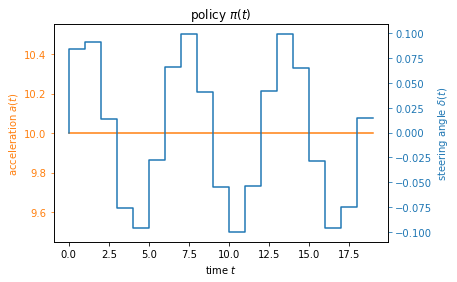

In [7]:
# Define a policy to test the system
acceleration = 10 # Fix a constant longitudinal acceleration 
policy = lambda _, t: np.array([[acceleration],
                               [0.1 * np.sin(t)]])

time = np.arange(0,20)
input_trajectory = np.array([policy(None, t) for t in time])

fig, ax1 = plt.subplots()
plt.title("policy $\pi(t)$")
ax1.step(time, np.array([policy(None, t)[0] for t in time]), color="tab:orange")
ax1.set_ylabel("acceleration $a(t)$", color="tab:orange");
ax1.tick_params('y', colors='tab:orange')

ax2 = ax1.twinx()
ax2.step(time, np.array([policy(None, t)[1] for t in time]), color="tab:blue")
ax2.set_ylabel("steering angle $\delta(t)$", color="tab:blue")
ax2.tick_params('y', colors='tab:blue')
ax1.set_xlabel("time $t$")

plt.show()

Combining this policy with the previously implemented dynamics, we obtain a closed loop system, for which we can compare our integrators. 

Let us first set some **parameters** 

In [8]:
ts = 0.05                    # Sample time
x = np.array([[0,0,0,0]]).T  # initial state: 4 x 1 vector 
steps=100                    # Number of steps to simulate [int]


Now, we construct a discrete time dynamics $x^+ = f_{\mathrm{d}}(x, u)$, which are supposed to approximate the solution to the ode:
$$
    f_{\mathrm{d}}(x,u) = \int_{t}^{t+T_{\mathrm{s}}} f(x(\tau),u) \mathrm{d} \tau, \quad x(t) = x
$$


In [9]:
# %matplotlib inline
from scipy.integrate import odeint  # Load scipy integrator as a ground truth

# Discrete-time dynamics under forward Euler 
dynamics_fw_euler = forward_euler(kinematic_bicycle, ts)   
# Discrete-time dynamics "ground truth"
def true_discretized_dynamics(x,u,t):
    f = lambda x,t: np.array(kinematic_bicycle(x, u)).reshape([x.size])
    y = odeint(f, x.reshape([x.size]), [t, t+ts])
    return y[-1].reshape((x.size, 1))

#### 🔧 Task: Simulate the "true" dynamics and compare with a simulation of your implementations of the integrators.

❓ Play around a bit with the value of `acceleration` in the policy defined above and compare the size of the integration errors at the end of the simulation. What do you observe? Can you explain this?

❓ What other parameter do you expect to play an important role in the accuracy (and therefore the choice) of your integration scheme? 

💡**Answer**: The error accumulates over time, since we are using the previous (erroneous) point to compute the next point from. The larger the acceleration, the more the velocity will change over the sampling period. As a result, the error in the Forward Euler method resulting from keeping the velocity constant will also be larger as the acceleration increases. This is of course relative to the size of the sampling period; the smaller the sampling period, the smaller the errors.

Iteration 50/100
Iteration 100/100
Iteration 50/100
Iteration 100/100


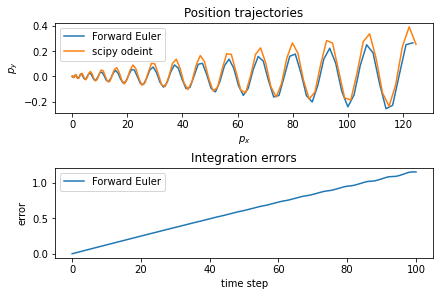

In [10]:
# Simulate the ground truth dynamics 
state_true, controls_true = simulate(x, dynamics=true_discretized_dynamics, policy=policy, time_steps=steps)

# Simulate the forward Euler dynamics
state, controls = simulate(x, dynamics=dynamics_fw_euler, 
                              policy=policy, time_steps=steps)


# Plot the results
fig, axes = plt.subplots(2,1, constrained_layout = True)
axes[0].plot(state[0,:], state[1,:], label="Forward Euler")
axes[0].plot(state_true[0,:], state_true[1,:], label="scipy odeint")
axes[0].set_xlabel("$p_{x}$")
axes[0].set_ylabel("$p_{y}$")
axes[0].legend()
axes[0].set_title("Position trajectories")

error_fw_euler = np.linalg.norm(state_true-state, axis=0)
axes[1].plot(error_fw_euler, label="Forward Euler")
axes[1].set_xlabel("time step")
axes[1].set_ylabel("error")
axes[1].set_title("Integration errors")
axes[1].legend();

We can conclude that for both methods, the approximation error accumulates over time, as the new state is computed based on an erroneous estimate in the previous time step. Fortunately, however, if the open loop prediction horizon is not too long, this error is not too severe and can be corrected by observing the actual new state online.

## Intermezzo: animation 
It's often convenient to represent a simulation in animated form. We provide a small piece of code for this (see `utilities.py`). To use it, simply, supply it a sequence states and inputs that it needs to plot. Furthermore, it needs the vehicle dimensions to draw a rectangle from (these were defined above and stored in `vehicle_dims`) and the sampling time `ts`. 

**Example**: The code block below demonstrates the usage of the given animation code on some dummy data.

🔧 **Task:** Try it out on the output of your simulation from the block above.
 
⚠ *NOTE: It can take a few seconds for the animation to generate!*

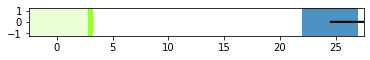

In [11]:
# %matplotlib inline
from utilities import Animation

# Generate some dummy data. Replace these arrays with the data generated above! 
datalen = 100 
state = np.vstack([np.linspace(0,5, datalen)**2, 
                   np.zeros(datalen), 
                   np.zeros(datalen),
                   np.linspace(0,5,datalen)]
                )
controls = np.vstack([np.zeros(datalen), 
                   np.zeros(datalen)])
#------------------------------------------------------
# Generate animation! 
from IPython.display import HTML
animator = Animation(state,controls, *vehicle_dims)
HTML(animator.build(ts).to_jshtml())

## Optimal control problem

We are now ready to start actually controlling our vehicle. To do so we will start by constructing an optimal control problem specifying our requirements.

### Building a nonlinear program in 📖 [CasADi](https://web.casadi.org/)
We will use CasAdi as a modelling language for our problem. CasADi is 
an automatic differentiation library with powerful C-code generation capabilities,
which provides bindings to many popular optimization solvers. 
In today's tutorial, we will pass our optimization problem to a custom 
solver, but the modelling procedure for any other solver that is interfaced 
with CasADi is the same. 

CasADi expects an optimization problem of the form 
$$
    \begin{aligned}
        &\operatorname{Minimize}_{x}&& f(x) \\ 
        &\text{s.t.}&& \underline{x} \leq x \leq \bar{x}\\ 
        &&& \underline{g} \leq g(x) \leq \bar{g}
    \end{aligned}
$$
with $x \in \mathbb{R}^{n}$ the decision variable, which may be bounded above and below 
using $\underline{x}, \bar{x}$, and $g: \mathbb{R} \to \mathbb{R}^m$ a 
possibly nonlinear constraint function with given lower and upper bounds.

To represent this in the code, $x$ is an object of the CasADi `SX.sym`
class and $g$ and $f$ are expressions (which can be built from regular mathematical functions that are available in Python). 

📖 See [The CasADi documentation](https://web.casadi.org/docs/#nonlinear-programming) for more info. 


### The optimal control problem 
The goal of our controller will be to drive our vehicle from a given initial state to a desired setpoint. For convenience, we will put this set-point at the origin, but this could be any other reference state.
We fix a prediction horizon $N$ and consider the standard additive cost which penalizes at every time step the deviations of the current state from the given setpoint. 
This yields a cost function 
$$
    V(x,u) = \sum_{k=0}^{N-1} x_k^\top Q x_k + u_k^\top R u_k + x_N^\top Q_N x_N, 
$$
where $x_0 = x$ and $x_k = f(x_k, u_k)$ for $k = 0, \dots, N-1$.
For convenience, we'll take $Q_N = 10 Q$.

❗*Note: a careful choice of $Q_N$ is crucial in proving certain properties of the closed-loop system, such as stability.
For this exercise in particular, we will not worry too much about this.*

We will assume there are physical limits on the actuation of the vehicle, as well as bounds on the system states: 
$$
    \begin{aligned}
        \underline{u}  &\leq u_k \leq \bar{u}, \quad k = 0, \dots, N-1\\
        \underline{x}  &\leq x_k \leq \bar{x}, \quad k = 0, \dots, N-1,
    \end{aligned}
$$ 
with $\underline{x} = (-50, -50, - 0.8 \frac{\pi}{2}, -10)$, $\bar x = (50, 50, 0.8 \frac{\pi}{2}, 10)$, and 
$\underline{u} = (-5, -\frac{\pi}{3})$, $\bar{u} = (5, \frac{\pi}{3})$.

We will implement our controller using a *sequential approach* (a.k.a. single-shooting) so that
$x_k$ will be represented as a nonlinear function of the initial state $x_0$ (which is a parameter) and the 
inputs up to time step $k$, namely $x_{k+1} = f(\,\cdot\,, u_{k-1}) \circ \dots \circ f(x_0, u_0)$.

As a result, $x_k$, $k=1,\dots,N$ will make up the output of the constraint function $g$. 



#### 🔧 Task: Construct an optimal control problem using [CasADi](https://web.casadi.org/)
Complete the function below, which takes as argument the prediction horizon (`int`), and returns a dictionary containing the information that describe the nlp above. See the docstring of the function for a more precise specification. 
Under the hood, CasADi will compute and store the required gradient (and Hessian) information that a solver would need. We will not use Hessian information, as we will be using an ALM solver with PANOC as an inner solver, which is designed to be matrix free. This is potentially a significant advantage in control applications, which are often run on underpowered embedded devices!

For the quadratic cost function, you can use the following parameter values
$$
Q = \operatorname{diag}(1,1,10,1), \quad 
R = 0.1 I_2. 
$$
❓ Suppose that we do not care about driving any state entry to zero particularly fast, what reason could we have for increasing the weight for the third state entry (the heading angle)?

*hint*: think about the units/the range of values that each state variable can take. 

To propagate the states, use your forward Euler method from before, i.e., `x = dynamics_fw_euler(x,u,t)`

### Solution

💡 The heading angle takes values in the interval $[-\pi, \pi]$, whereas, the position and velocity can take values which are about an order of magnitude larger. In order to give equal importance to each state in our cost, we have to scale by these units. 

In [12]:
from typing import Tuple 

def construct_ocp(horizon: int) -> Tuple[cs.nlpsol, np.ndarray, np.ndarray]: 
    """
    Given the prediction horizon, build a nonlinear program that represents the parametric optimization problem described above, with the initial state x as a parameter. 
    Use a single shooting formulation, i.e., do not define a new decision variable for the states, but rather write them as functions of the initial state and the control variables. Also return the lower bound and upper bound on the decision variables and constraint functions:

    Args: 
        horizon [int]: decision horizon  
    Returns: 
        solver [dict]: the nonlinear program as a dictionary: 
            {"f": [cs.SX] cost (as a function of the decision variables, built as an expression, e.g., x + y, where x and y are CasADi SX.sym objects),
             "g": [cs.Expression] nonlinear constraint function as 
             an expression of the variables and the parameters. 
             These constraints represent the bounds on the state. 
             "x": [cs.SX] decision_vars (all control actions over the prediction horizon (concatenated into a long vector)), 
             "p": [cs.SX] parameters (initial state vector)} 
        bounds [dict]: the bounds on the constraints 
            {"lbx": [np.ndarray] Lower bounds on the decision variables, 
             "ubx": [np.ndarray] Upper bounds on the decision variables, 
             "lbg": [np.ndarray] Lower bounds on the nonlinear constraint g, 
             "ubg": [np.ndarray] Upper bounds on the nonlinear constraint g 
            }
    """
    x0 = cs.SX.sym("x0", (4,1))
    x = x0
    Q = np.eye(x.numel())
    Q[2,2] *= 10
    QT = 10*Q
    R = 0.1 * np.eye(2) 
    cost = 0
    u = [cs.SX.sym(f"u_{t}", (2,1)) for t in range(horizon)]

    states_lb = np.array([-50, -50, - 0.8 * np.pi / 2, -10])
    states_ub = np.array([+50, +50, + 0.8 * np.pi / 2, +10])
    
    # states_lb = -np.inf * (np.ones(4))
    # states_ub = np.inf * (np.ones(4))
    inputs_lb = np.array([-5, -np.pi / 3])
    inputs_ub = np.array([+5, +np.pi / 3])

    lbx = []
    ubx = []
    g = [] 
    lbg = []
    ubg = []
    for i in range(horizon):
        cost += x.T @ Q @ x + u[i].T @ R @ u[i]
        x = dynamics_fw_euler(x, u[i], i)
        lbx.append(inputs_lb)
        ubx.append(inputs_ub)
        g.append(x)   # Bound the state 
        lbg.append(states_lb)
        ubg.append(states_ub)
    
    cost += x.T @ QT @ x

    variables = cs.vertcat(*u)
    nlp = {"f": cost,
           "x": variables,
           "g": cs.vertcat(*g),
           "p": x0}
    bounds = {"lbx": cs.vertcat(*lbx), 
              "ubx": cs.vertcat(*ubx), 
              "lbg": cs.vertcat(*lbg), 
              "ubg": cs.vertcat(*ubg), 
            }
 
    return nlp, bounds


In [142]:
import panocpy as pa 
from datetime import timedelta

def get_ALM_solver(lbfgsmem = 20, max_iter=30, 
                   max_time_seconds=1) -> pa.ALMSolver: 
    
    tol = 1e-4
    
    verbose = False
    # Parameters about the inner solver 
    panocparams = {
        "max_iter": 1000,
        "max_time": timedelta(seconds=0.5),
        "print_interval": 0 if verbose else 0,
        "stop_crit": pa.PANOCStopCrit.FPRNorm,
        "update_lipschitz_in_linesearch": True,
    }

    innersolver = pa.PANOCSolver(
        pa.PANOCParams(**panocparams),
        pa.LBFGSParams(memory=lbfgsmem),
    )
    
    # Parameters about the outer solver 
    almparams = pa.ALMParams(
        max_iter=max_iter,
        max_time=timedelta(seconds=max_time_seconds),
        print_interval=1 if verbose else 0,
        preconditioning=False,
        ε=tol,
        δ=1e-2,
        Δ=10,
        Σ_0=1e5,
        Σ_max=1e13,
    )

    solver = pa.ALMSolver(almparams, innersolver)
    return solver

### Compiling the optimization problem 
Now that we have constructed a CasADi representation of the optimal control problem, we can generate efficient C-code to evaluate the cost and the gradient, which is used by the optimizer. `panocpy` provides useful utilities to do this easily:

Let's set our prediction horizon to some (rather large) number and compile the parametric optimal control problem.

In [143]:
from utilities import compile_ocp
prediction_horizon = 30                         # Set the prediction horizon 

nlp_description, bounds = construct_ocp(prediction_horizon)   # Build the optimizer
problem = compile_ocp(nlp_description, bounds)

n=60, m=120, p=4
temp dir:  /tmp/panoc_ulmw9dwy
c-file:  /tmp/panoc_ulmw9dwy/mpcproblem.c
/tmp/panoc_ulmw9dwy/mpcproblem.so


#### 🔧 Task: simulate the open-loop trajectory 
Call the optimizer to obtain the optimal sequence of control actions and use these to simulate the state trajectory for $N$ steps.  

In [144]:
# Make a solver
solver = get_ALM_solver()

# Set initial state and some initial guess
x_init = np.array([-20, -5, 0, 0]).reshape((4,1))      # Initial state as column vector 
problem.param = x_init

initial_guess_primal = np.ones((2*prediction_horizon,)) 
initial_guess_dual = np.zeros((4*prediction_horizon,)) 

In [145]:
y_sequence, u_sequence, stats = solver(problem, initial_guess_dual, initial_guess_primal)
# solver = cs.nlpsol('Solver', 'ipopt', nlp_description, {'verbose_init': False, 'print_time': False, 'ipopt':
#                                                 {'print_level': 0}})
# solution = solver(p=x_init, **bounds)
# u_sequence = solution["x"].toarray().reshape((2,-1), order="F")
# print(u_sequence[:,0])
utilities.print_solver_stats(stats)
u_sequence = u_sequence.reshape((2,-1), order="F")  # Reshape into the convenient form

# u_sequence = solution["x"].reshape((2,-1))         # Extract the control sequence back from the solution 
def policy(x,t):                                   # Write the solution as a function of time 
    return u_sequence[:,t]                         # At time t, use the t'th element in the sequence 

n_steps = u_sequence.shape[1]                 # We can only simulate forward as many steps as we have predicted in the MPC problem. 
print("Number of steps: ", n_steps)
x_predicted, _ = simulate(x0=x_init, dynamics=dynamics_fw_euler, policy=policy, time_steps=n_steps) 

# Compare against a simulation with the true dynamics
x_true, _ = simulate(x0=x_init, dynamics=true_discretized_dynamics, policy=policy, time_steps=n_steps)

SolverStatus.Converged - 'δ': 0.0 - 'ε': 5.3636251117650247e-05 - outer its. 5
Number of steps:  30


In [146]:
def plot_input_sequence(u_sequence): 
    plt.subplot(2,2, (1,3))
    plt.title("Control actions")
    plt.plot(u_sequence[0,:], u_sequence[1,:], marker=".") 
    plt.xlabel("$a$")
    plt.ylabel("$\delta$");
    plt.subplot(2,2,2)
    plt.title("Steering angle")
    plt.plot(u_sequence[1,:].squeeze(), marker=".") 
    plt.ylabel("$\delta$");
    plt.subplot(2,2,4)
    plt.title("Acceleration")
    plt.plot(u_sequence[0,:].squeeze(), marker=".") 
    plt.ylabel("$a$");
    plt.xlabel("$t$")
    plt.tight_layout()


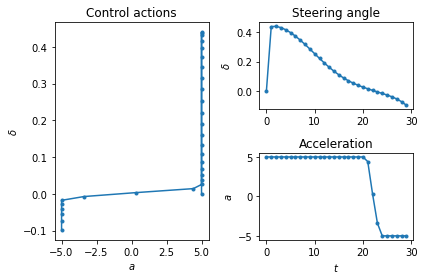

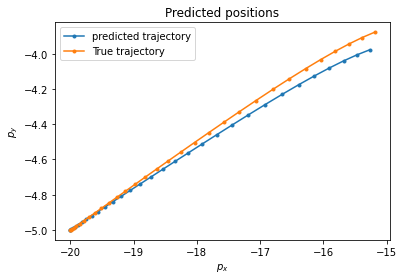

In [147]:
plt.figure() 
plot_input_sequence(u_sequence)

plt.figure() 
plt.title("Predicted positions")
plt.plot(x_predicted[0,:], x_predicted[1,:], label="predicted trajectory",marker=".") 
plt.plot(x_true[0,:], x_true[1,:], label="True trajectory",marker=".")
plt.legend()
plt.xlabel("$p_x$")
plt.ylabel("$p_y$") ; 

## Model error 

So far, everything looks nice, but of course, this open-loop simulation only reveals what our controller predicted. 
Now, suppose that there is some model error and the true vehicle dynamics are given by the following function:

In [148]:
def kinematic_bicycle_true(x,u):
        """
        Implements the continuous-time bicycle dynamics
        The bicycle dynamics are a set of (differential) equations which model
        the motions of a vehicle by assuming that the left and right wheels stay
        perfectly parallel at all times.


        The input u consists of [acceleration, steering angle]

        Args:gewoon 
            x: The current state vector, consisting of
                   - X: the x-position.
                   - Y: the y-position.
                   - psi: the angle of the vehicle with respect to the road.
                   - v: the speed of the vehicle (scalar).
            u: The input u consists of [acceleration, steering angle]

        Returns:
            the time derivative of the state vector
        """
        lr = 0.3*VEHICLE_LENGTH 
        l = VEHICLE_LENGTH

        b = cs.arctan(lr/l * np.tan(u[1]))
        res = [x[3] * np.cos(x[2]+b),
               x[3] * np.sin(x[2]+b),
               x[3] * np.sin(b),
               u[0]]
        return cs.vertcat(*res)

def true_system(x,u,t):
    f = lambda x,t: np.array(kinematic_bicycle_true(x, u)).reshape([x.size])
    y = odeint(f, x.reshape([x.size]), [t, t+ts])
    return y[-1].reshape((x.size, 1))

Now, running the simulation again, using `true_system` for the dynamics... 

❓What do you observe? 

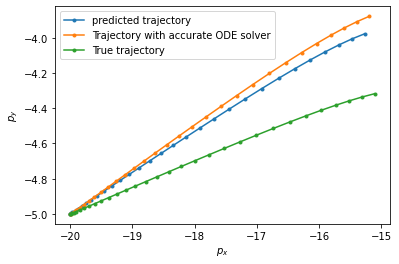

In [149]:
# Compare against a simulation with the true dynamics
x_with_error, _ = simulate(x0=x_init, dynamics=true_system, policy=policy, time_steps=n_steps)

plt.figure()
plt.plot(x_predicted[0,:], x_predicted[1,:], marker=".", label="predicted trajectory") 
plt.plot(x_true[0,:], x_true[1,:], label="Trajectory with accurate ODE solver",marker=".")
plt.plot(x_with_error[0,:], x_with_error[1,:], label="True trajectory",marker=".",)
plt.legend()
plt.xlabel("$p_x$")
plt.ylabel("$p_y$"); 


## Introducing feedback with MPC 

We can repeat the previous simulation by including the solution of the optimization problem into the definition of the control policy. 

#### 🔧 Task: redefine the policy to use receding horizon
Use the output of the function `build_optimizer` you wrote before to repeat the optimization problem every time the policy is called. This way, you obtain an MPC controller instead of simply an open-loop sequence of control actions. 

You can even reduce the prediction horizon to 20 for this test. This means you'll need to compile a new optimal control problem! Use `construct_ocp` as before.


In [150]:
prediction_horizon = 20
nlp_description, bounds = construct_ocp(prediction_horizon)   # Build the optimizer 
problem = compile_ocp(nlp_description, bounds) 
problem.param = x_init

n=40, m=80, p=4
temp dir:  /tmp/panoc_dfnfafyn
c-file:  /tmp/panoc_dfnfafyn/mpcproblem.c
/tmp/panoc_dfnfafyn/mpcproblem.so


### Solution

In [151]:
class WarmStartedPolicy: 
    
    def __init__(self, solver:pa.ALMSolver,
                 problem: pa.ProblemWithParam): 
        self.alm_solver=solver
        self.problem = problem 
        self.stats = None  # Useful for debugging purposes. 
        self.initial_guess_primal = np.zeros(problem.n)
        self.initial_guess_dual = np.zeros(problem.m)

    def __call__(self, x, t):
        x = cs.DM(x)
        self.problem.param = cs.vertcat(x, self.problem.param[x.numel():])
        sol_dual, sol_primal, stats = self.alm_solver(self.problem, self.initial_guess_dual, self.initial_guess_primal)
        self.stats = stats 
        self.initial_guess_dual = sol_dual
        self.initial_guess_primal = sol_primal
        return sol_primal[0:2]    

# Define the MPC policy.
policy = WarmStartedPolicy(solver, problem) 

### Task: simulate
Simulate the MPC controller, both for the dynamics used and for the true dynamics given above, and verify that the performance of the controller has improved. 

Iteration 50/200
Iteration 100/200
Iteration 150/200
Iteration 200/200
Iteration 50/200
Iteration 100/200
Iteration 150/200
Iteration 200/200


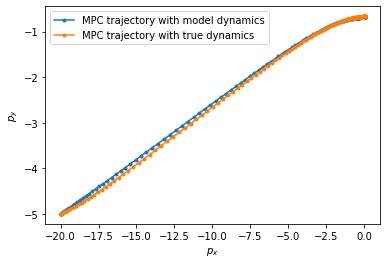

In [152]:
n_steps = 200

x_simplified, _ = simulate(x0=x_init, dynamics=dynamics_fw_euler, policy=policy, time_steps=n_steps)
x_true, u_true = simulate(x0=x_init, dynamics=true_system, policy=policy, time_steps=n_steps)

plt.figure()
plt.plot(x_simplified[0,:], x_simplified[1,:], marker=".", label="MPC trajectory with model dynamics") 
plt.plot(x_true[0,:], x_true[1,:], marker=".", label="MPC trajectory with true dynamics")
plt.legend()
plt.xlabel("$p_x$")
plt.ylabel("$p_y$"); 

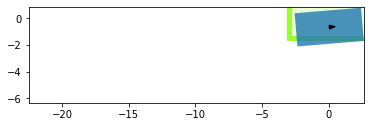

In [153]:
## Animation for the true dynamics 
%matplotlib inline
animator = Animation(x_true,u_true,*vehicle_dims);
HTML(animator.build(ts).to_jshtml())

## Extension: obstacle avoidance 

We can now repeat the previous example, but now extending it to a more interesting/realistic scenario. Suppose that 
we have a number of obstacles in the scene, which we represent by a location $o = (o_x, o_y)$ and a size $r$.

#### 🔧 Task: write down the collision avoidance constraint 

Given an circular obstacle with position $o = (o_x, o_y)$ and size $r$; write down the condition on the position such that for all heading angles $\theta$, 
the vehicle (of length $l$ and width $w$) does not intersect with the obstacle. 

Is the corresponding constraint convex or not?

#### 💡 Solution

Overapproximate the rectangle by the diagonal length: 
$r_r = \frac{1}{2} \sqrt{l^2 + w^2}$. By direct calculation: the vehicle does not intersect with the obstacle if 
$$
    \| o - p \| \geq r_r +  r. 
$$
 More explicitly, we can write: 
$$
    (o - p)^\top (o-p) \geq \frac{l^2 + w^2}{4} + r^2.
$$

#### 🔧 Task: Reimplement `construct_ocp` with collision avoidance constraints 

Implement a function to build a parametric optimizer like before, but now supporting collision avoidance constraints. 
Based on the argument `n_obstacles`, introduce a parameter vector containing all the positions $o_{i,x}, o_{i,y}$ of the obstacles $i = 1, \dots,n_o$ , and their radii $r_{i}$. That is, 
the parameter vector is of the form 
$$
    p = \begin{bmatrix}
        x_0 \\
        o_{1,x}\\
        o_{1,y}\\
        o_{2,x}\\
        o_{3,y}\\
        \vdots \\
        o_{n_o,x}\\
        o_{n_o,y}\\
        r_{1}\\ 
        \vdots \\ 
        r_{n_o}
    \end{bmatrix}
$$




#### 💡 Solution

In [154]:
from typing import Tuple 

def construct_ocp_constrained(horizon: int, n_obstacles: int) -> Tuple[dict, dict]:
    """
    Given the prediction horizon, build a CasADi nlp object that represents the parametric optimization problem described above, with the initial state x as a parameter. 
    Use a single shooting formulation, i.e., do not define a new decision variable for the states, but rather write them as functions of the initial state and the 
    control variables. Also return the lower bound and upper bound on the decision variables and constraint functions: 

    Args: 
        horizon [int]: decision horizon  
        n_obstacles [int]: number of obstacles in the scene
    Returns: 
        solver [dict]: the nonlinear program as a dictionary: 
            {"f": [cs.Expression] cost (as a function of the decision variables, built as an expression, e.g., x + y, where x and y are CasADi SX.sym objects),
             "g": [cs.Expression] nonlinear constraint function as 
             an expression of the variables and the parameters. 
             The constraints are both the original state bounds and 
             the collision avoidance constraints. 
             "x": [cs.SX] decision_vars (all control actions over the prediction horizon (concatenated into a long vector)),
             "p": [cs.SX] parameters (initial state vector, obstacle positions, obstacle radii) concatenated into one column vector} 
        bounds [dict]: the bounds on the constraints 
            {"lbx": [np.ndarray] Lower bounds on the decision variables, 
             "ubx": [np.ndarray] Upper bounds on the decision variables, 
             "lbg": [np.ndarray] Lower bounds on the nonlinear constraint g, 
             "ubg": [np.ndarray] Upper bounds on the nonlinear constraint g 
            }
    """

    # Define variables and parameters. 
    x0 = cs.SX.sym("x0", (4,1))
    obs_pos = [cs.SX.sym(f"o_{i}", (2,1)) for i in range(n_obstacles)]
    obs_r   = [cs.SX.sym(f"ro_{i}") for i in range(n_obstacles)]
    r_vehicle = 0.5 * np.linalg.norm(vehicle_dims)
    u = [cs.SX.sym(f"u_{t}", (2,1)) for t in range(horizon)]

    # Initialize the cost at zero and define the cost weights  
    # state weights matrix
    Q = cs.diagcat(1, 1, 1, 0.1)
    QT = Q 
    # controls weights matrix
    R = cs.diagcat(1e-1, 1)
    cost = 0

    # Define the bounds for every time step 
    # -- State bounds
    states_lb = np.array([-30, -20, -np.pi / 2, -10])
    states_ub = np.array([+30, +20,  np.pi / 2, +10])
    
    # -- Input bounds 
    inputs_lb = np.array([-8, -np.pi/4])
    inputs_ub = np.array([+3, +np.pi/4])

    # Initialize containers for the constraints and constraint bounds 
    lbx = []
    ubx = []
    g = [] 
    lbg = []
    ubg = []

    # Initialize the current state to the initial value
    x = x0
    for i in range(horizon):
        # Rollout the simulation horizon, accumulating costs and constraints 
        cost += x.T @ Q @ x + u[i].T @ R @ u[i]
        # Update the state 
        x = dynamics_fw_euler(x, u[i], i)
        # Bound the controls 
        lbx.append(inputs_lb)
        ubx.append(inputs_ub)
        # Bound the states  
        g.append(x)
        lbg.append(states_lb)
        ubg.append(states_ub)
        
        # [NEW] Impose collision avoidance 
        pos = x[:2] # Get the position from the state vector 
        for o_pos, o_rad in zip(obs_pos, obs_r):  # Loop over obstacles 
            d = pos - o_pos                       # position difference 
            g.append(d.T@d - (o_rad + r_vehicle)**2)
            lbg.append(0)
            ubg.append(np.inf)

    # Add terminal costs/constraints 
    cost += x.T @ QT @ x
    
    for o_pos, o_rad in zip(obs_pos, obs_r):  # Loop over obstacles 
            d = pos - o_pos                       # position difference 
            g.append(d.T@d - (o_rad + r_vehicle)**2)
            lbg.append(0)
            ubg.append(np.inf)

    # Concatenate the variables and constraints, and package the problem into dicts 
    variables = cs.vertcat(*u)
    parameters = cs.vertcat(x0, *obs_pos, *obs_r)
    nlp = {"f": cost,
           "x": variables,
           "g": cs.vertcat(*g),
           "p": parameters}
    bounds = {"lbx": cs.vertcat(*lbx), 
              "ubx": cs.vertcat(*ubx), 
              "lbg": cs.vertcat(*lbg), 
              "ubg": cs.vertcat(*ubg), 
            }
    return nlp, bounds

### Obstacle settings 

We introduce two obstacles that need to be avoided during the maneuver. 

In [155]:
obstacle_pos = [np.array([[-15,4]]).T, np.array([[-5,-8]]).T]  # positions 
# obstacle_pos = [np.array([[-10,-5]]).T] 
# obstacle_pos = [] 
obstacle_rad = [3,5]                                    # sizes 
# obstacle_rad = [3.]
# obstacle_rad = [] 
num_obstacles = len(obstacle_pos)
# Combine into parameter vector
if num_obstacles > 0:
    params_obst = np.vstack(obstacle_pos + obstacle_rad)  
else: 
    params_obst = [] 

#### 🔧 Task: Simulate open loop trajectory with model errors

Like before, but now with the constrained problem, simulate the solution under the model dynamics (forward Euler) and the true dynamics (using the given function `true_dynamics` with  scipy `odeint` for integration).

❓What do you observe? Are the obstacles correctly avoided for the true dynamics?

#### 💡 Solution

1. Build the problem 

In [167]:
from utilities import compile_ocp
x_init = np.array([[-20, -5, 0, 0]]).T
horizon = 60

# Define the problem 
nlp_description, bounds = construct_ocp_constrained(horizon, num_obstacles)
# Compile the OCP
problem = compile_ocp(nlp_description, bounds)
if num_obstacles > 0: 
    params = np.vstack([x_init, params_obst])
else: 
    params = x_init 
    
print("params:\n", params)
problem.param = params

n=120, m=362, p=10
temp dir:  /tmp/panoc_w5sq0ecm
c-file:  /tmp/panoc_w5sq0ecm/mpcproblem.c
/tmp/panoc_w5sq0ecm/mpcproblem.so
params:
 [[-20]
 [ -5]
 [  0]
 [  0]
 [-15]
 [  4]
 [ -5]
 [ -8]
 [  3]
 [  5]]


In [168]:
# Instantiate a solver. This time, we can increase the number of iterations etc. a bit to account for the larger horizon. 
solver = get_ALM_solver(max_iter=50, max_time_seconds=60)

2. Set the problem parameters and call the solver to obtain a solution

In [169]:
initial_guess_primal = np.zeros((problem.n,))
initial_guess_dual = np.zeros((problem.m,))

_, u_sequence, stats = solver(problem, initial_guess_dual, initial_guess_primal)
utilities.print_solver_stats(stats)
u_sequence = u_sequence.reshape((2,-1), order="f")         # Extract the control sequence back from the solution

# solver = cs.nlpsol('Solver', 'ipopt', nlp_description, {'verbose_init': False, 'print_time': False, 'ipopt':
#                                                 {'print_level': 0}})
# solution = solver(p=params, **bounds)
# u_sequence = solution["x"].toarray().reshape((2,-1), order="F")


SolverStatus.Converged - 'δ': 1.926291522380552e-05 - 'ε': 8.250063122044321e-05 - outer its. 28


3. Define the open-loop policy and simulate it on the model system and the true system

In [170]:
def policy(x,t):  # Write the solution as a function of time 
    return u_sequence[:,t]  # At time t, use the t'th element in the sequence 

n_steps = u_sequence.shape[1]                 # We can only simulate forward as many steps as we have predicted in the MPC problem. 
x_predicted, _ = simulate(x0=x_init, dynamics=dynamics_fw_euler, policy=policy, time_steps=n_steps)

# Compare against a simulation with the true dynamics
x_true, _ = simulate(x0=x_init, dynamics=true_system, policy=policy, time_steps=n_steps)


Iteration 50/60
Iteration 50/60


4. Plot the results

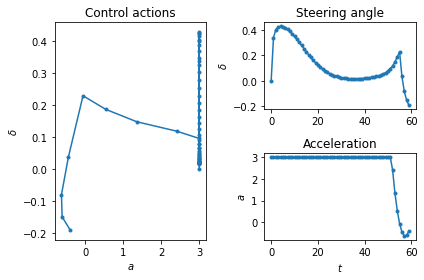

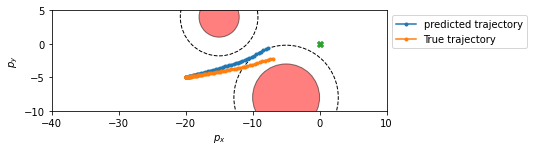

In [171]:
plt.figure() 
plot_input_sequence(u_sequence)

plt.figure()

def draw_scene(): 
    ax = plt.gca()
    ax.axis("square")

    for o_p, o_r in zip(obstacle_pos, obstacle_rad):
        c1 = plt.Circle(o_p, radius=o_r, ec="k", fc="red", alpha=0.5)
        c2 = plt.Circle(o_p, radius=o_r+0.5*np.sqrt(VEHICLE_LENGTH**2+VEHICLE_WIDTH**2), ec="k", fc=(0,0,0,0), linestyle="--")
        ax.add_artist(c1)
        ax.add_artist(c2)
    ax.scatter([0], [0], color="tab:green", marker="X")
    plt.xlim([-40, 10])
    plt.ylim([-10, 5])

draw_scene()
plt.plot(x_predicted[0,:], x_predicted[1,:], marker=".", label="predicted trajectory") 
plt.plot(x_true[0,:], x_true[1,:], marker=".", label="True trajectory")
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.xlabel("$p_x$")
plt.ylabel("$p_y$"); 


### MPC with obstacle avoidance 

To reduce the computation, we reduce the prediction horizon again to 20 steps. Now, define the policy that solves the optimal control problem in receding horizon. Compare again the performance on the model dynamics with the forward Euler integrator to the performance on the true system. 


#### Solution

In [63]:
horizon = 20
ocp, bounds = construct_ocp_constrained(horizon, num_obstacles)
problem = compile_ocp(ocp, bounds)

# Don't forget to add the obstacle information as parameters!
if num_obstacles > 0: 
    params = np.vstack([x_init, params_obst])
else: 
    params = x_init 
problem.param = params

n=100, m=302, p=10
temp dir:  /tmp/panoc_075y_3hl
c-file:  /tmp/panoc_075y_3hl/mpcproblem.c
/tmp/panoc_075y_3hl/mpcproblem.so


In [64]:
# IPOPT
ipopt_solver = cs.nlpsol('Solver', 'ipopt', ocp, {'verbose_init': False, 'print_time': False, 'ipopt':
                                           {'print_level': 0, 'tol': 1e-5, 'constr_viol_tol': 1e-4}})
solution = ipopt_solver(p=params, **bounds)
u_sequence = solution["x"].toarray().reshape((2,-1), order="F")

class PolicyIpopt: 
    def __init__(self, solver, params): 
        self.solver = solver 
        self.params = params 

    def __call__(self, x, t):
        x = cs.DM(x)
        self.params = cs.vertcat(x, self.params[x.numel():])
        solution = self.solver(p=self.params, **bounds)
#         infeas = np.max(self.solver.stats()['iterations']['inf_pr'])
#         if not self.solver.stats()["success"]: 
#             print(f"solver failed with status: {self.solver.stats()['return_status']}") 
#         elif infeas > 1: 10
#             print(f"Large primal infeasibility: {infeas}")
#         for o_pos, o_rad in zip(obstacle_pos, obstacle_rad):
#             d = x[0:2] - o_pos
#             print(np.linalg.norm(d) >= (o_rad + 0.5*np.linalg.norm(vehicle_dims)))
# #             print(d.T@d - o_rad**2 - 0.25*np.linalg.norm(vehicle_dims)**2) 
        u_sequence = solution["x"].toarray()
        
        return u_sequence[0:2]
ipopt_policy = PolicyIpopt(ipopt_solver, params)

In [65]:
# Instantiate a solver 
solver = get_ALM_solver()
# Define the MPC policy.
pol = WarmStartedPolicy(solver, problem) 

def policy(x,t): 
    u = pol(x,t)
    utilities.print_solver_stats(pol.stats)
    return u 

# policy = ipopt_policy


In [66]:
n_steps = 150

x_simplified, u_simplified = simulate(x0=x_init, dynamics=dynamics_fw_euler, policy=policy, time_steps=n_steps)
x_true, u_true = simulate(x0=x_init, dynamics=true_system, policy=policy, time_steps=n_steps)

SolverStatus.Converged - 'δ': 0.0 - 'ε': 9.41051615570565e-05 - outer its. 5
SolverStatus.Converged - 'δ': 0.0 - 'ε': 6.717876325784689e-05 - outer its. 5
SolverStatus.Converged - 'δ': 2.9572749582484903e-07 - 'ε': 7.529337184486451e-05 - outer its. 5
SolverStatus.Converged - 'δ': 1.5519470508706945e-07 - 'ε': 9.954867410896795e-05 - outer its. 5
SolverStatus.Converged - 'δ': 7.086761399932584e-09 - 'ε': 9.597877862432824e-05 - outer its. 5
SolverStatus.Converged - 'δ': 1.606320374492043e-06 - 'ε': 9.096224991722579e-05 - outer its. 5
SolverStatus.Converged - 'δ': 4.662281369860466e-07 - 'ε': 9.857139831837003e-05 - outer its. 5
SolverStatus.Converged - 'δ': 2.4426445079939185e-06 - 'ε': 9.402721354234699e-05 - outer its. 5
SolverStatus.Converged - 'δ': 1.0496108515667402e-06 - 'ε': 6.02309433297421e-05 - outer its. 5
SolverStatus.Converged - 'δ': 2.636965213298481e-06 - 'ε': 9.660371898689846e-05 - outer its. 5
SolverStatus.Converged - 'δ': 5.697297687845548e-06 - 'ε': 7.9085723584171

SolverStatus.Converged - 'δ': 0.0 - 'ε': 7.661940829373215e-05 - outer its. 5
SolverStatus.Converged - 'δ': 0.0 - 'ε': 8.817651832826456e-05 - outer its. 5
SolverStatus.Converged - 'δ': 8.974124199312428e-08 - 'ε': 7.904623436116864e-05 - outer its. 5
SolverStatus.Converged - 'δ': 1.1348895156970684e-08 - 'ε': 8.907729776375106e-05 - outer its. 5
SolverStatus.Converged - 'δ': 9.911786236216358e-08 - 'ε': 8.920014699320689e-05 - outer its. 5
SolverStatus.Converged - 'δ': 6.991528422872761e-07 - 'ε': 9.698369830957176e-05 - outer its. 5
SolverStatus.Converged - 'δ': 2.6333395197752907e-06 - 'ε': 8.25014666330226e-05 - outer its. 5
SolverStatus.Converged - 'δ': 1.8811132349583204e-06 - 'ε': 8.295718988948764e-05 - outer its. 5
SolverStatus.Converged - 'δ': 2.587626902084139e-06 - 'ε': 8.30683345804939e-05 - outer its. 5
SolverStatus.Converged - 'δ': 8.248006153621645e-07 - 'ε': 9.318672073987955e-05 - outer its. 5
SolverStatus.Converged - 'δ': 1.3974596129173733e-06 - 'ε': 9.3516940637528

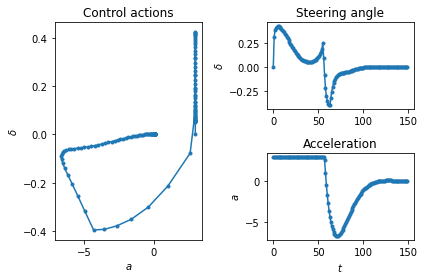

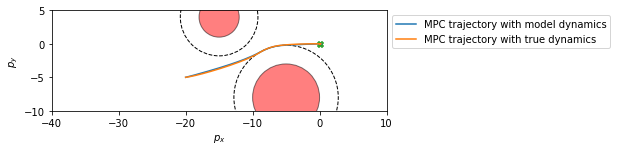

In [67]:
u_true = u_true.reshape((2,-1), order="F")
plt.figure() 
plot_input_sequence(u_true)

plt.figure()

draw_scene() 

plt.plot(x_simplified[0,:], x_simplified[1,:], label="MPC trajectory with model dynamics") 
plt.plot(x_true[0,:], x_true[1,:], label="MPC trajectory with true dynamics")

plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.xlabel("$p_x$")
plt.ylabel("$p_y$");

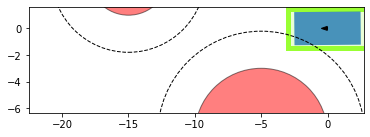

In [68]:
from utilities import Animation 
from IPython.display import HTML

animator = Animation(x_true, u_true, *vehicle_dims)
for o_p, o_r in zip(obstacle_pos, obstacle_rad):
    c1 = plt.Circle(o_p, radius=o_r, ec="k", fc="red", alpha=0.5)
    c2 = plt.Circle(o_p, radius=o_r+1/2*np.sqrt(VEHICLE_LENGTH**2+VEHICLE_WIDTH**2), ec="k", fc=(0,0,0,0), linestyle="--")
    animator.ax.add_artist(c1)
    animator.ax.add_artist(c2)

HTML(animator.build(ts).to_jshtml())